<a href="https://colab.research.google.com/github/SunshineGreeny/Dive-into-deep-learning-Pytorch/blob/main/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention Scoring Functions



Dot Product Attention
Masked Softmax Operation

In [ ]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

Tools

In [ ]:
def check_shape(tensor, expected_shape):
    """
    检查张量形状是否与预期形状匹配

    参数:
        tensor: 要检查的张量
        expected_shape: 预期的形状元组

    返回:
        如果形状匹配，返回原张量；否则抛出断言错误
    """
    assert tensor.shape == expected_shape, \
        f"Expected shape: {expected_shape}, but got: {tensor.shape}"
    return tensor

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(3.5, 2.5),
                  sharex=True,sharey=True,squeeze=False):
    """
    显示注意力权重的热力图

    参数:
        matrices: 注意力权重矩阵，形状为 (行数, 列数, 矩阵高度, 矩阵宽度)
        xlabel: x轴标签（通常是"Keys"）
        ylabel: y轴标签（通常是"Queries"）
        titles: 可选的子图标题
        figsize: 图形大小
    """
    num_rows,num_cols=matrices.shape[0],matrices.shape[1]

    # 创建子图网络
    fig,axes=plt.subplots(num_rows,num_cols,figsize=figsize,
                          sharex=True,sharey=True,squeeze=False)
    # 遍历所有矩阵并绘制热力图
    for i in range(num_rows):
        for j in range(num_cols):
            ax=axes[i,j]
            # 将张量转换为numpy数组并分离计算图
            matrix=matrices[i,j].detach().numpy()

            # 使用热力图显示矩阵
            pcm=ax.imshow(matrix,cmap='Reds')

            # 设置坐标轴标签
            if i==num_rows-1:#最后一行显示x轴标签
                ax.set_xlabel(xlabel)
            if j==0:#第一列显示y轴标签
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])

            # 隐藏刻度线
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')

    # Add a colorbar
    fig.colorbar(pcm, ax=axes.ravel().tolist())
    plt.show()

In [ ]:
def masked_softmax(X, valid_lens):
    """
    带掩码的softmax操作：对最后一个轴进行softmax，同时掩码掉无效位置

    参数:
        X: 输入张量，形状为 (batch_size, 序列长度, 特征维度)
        valid_lens: 有效长度，可以是标量或张量

    返回:
        应用了掩码和softmax后的张量
    """
    def _sequence_mask(X, valid_len, value=0):
        """
        内部函数：创建序列掩码

        参数:
            X: 输入张量
            valid_len: 每个序列的有效长度
            value: 掩码位置填充的值

        返回:
            应用了掩码的张量
        """
        maxlen = X.size(1)

        # 创建掩码：对于每个位置，如果索引小于有效长度则为True，否则为False
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]

        # 将掩码为False的位置设置为指定的值
        X[~mask] = value
        return X

    # 没有提供有效长度，直接返回标准sofemax
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape

        # 处理不同维度的有效长度
        if valid_lens.dim() == 1:
            # 如果是一维,复制到每个位置
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            # 如果是二维,展平
            valid_lens = valid_lens.reshape(-1)

        # 应用序列掩码,将无效位置设置为很小的值
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)

        # 应用softmax并恢复原始形状
        return nn.functional.softmax(X.reshape(shape), dim=-1)

Illustrate how this function works

In [ ]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5062, 0.4938, 0.0000, 0.0000],
         [0.4861, 0.5139, 0.0000, 0.0000]],

        [[0.3029, 0.2823, 0.4148, 0.0000],
         [0.3898, 0.3542, 0.2560, 0.0000]]])

In [ ]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4442, 0.2776, 0.2782, 0.0000]],

        [[0.6245, 0.3755, 0.0000, 0.0000],
         [0.3722, 0.3084, 0.1688, 0.1507]]])

In [ ]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
check_shape(torch.bmm(Q, K), (2, 3, 6))

tensor([[[4., 4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4., 4.]],

        [[4., 4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4., 4.]]])

Scaled Dot Product Attention

In [ ]:
class DotProductAttention(nn.Module):
    """
    缩放点积注意力机制

    原理：通过计算查询（Query）和键（Key）的点积来得到注意力分数，
          然后通过softmax得到注意力权重，最后对值（Value）进行加权求和

    公式：Attention(Q, K, V) = softmax(QK^T/√d)V
    """
    def __init__(self, dropout):
        """
        初始化缩放点积注意力

        参数:
            dropout: dropout比率，用于防止过拟合
        """
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        """
        前向传播

        参数:
            queries: 查询张量，形状为 (batch_size, 查询数量, 特征维度)
            keys: 键张量，形状为 (batch_size, 键值对数量, 特征维度)
            values: 值张量，形状为 (batch_size, 键值对数量, 输出维度)
            valid_lens: 有效长度，用于掩码

        返回:
            加权求和后的结果，形状为 (batch_size, 查询数量, 输出维度)
        """
        # 获取特征维度（用于缩放）
        d = queries.shape[-1]

        # 计算注意力分数：Q * K^T / √d
        # bmm: 批量矩阵乘法
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)

        # 应用带掩码的softmax得到注意力权重
        self.attention_weights = masked_softmax(scores, valid_lens)

        # 对注意力权重应用dropout，然后与值相乘得到最终输出
        return torch.bmm(self.dropout(self.attention_weights), values)

Illustrate how the `DotProductAttention` class works

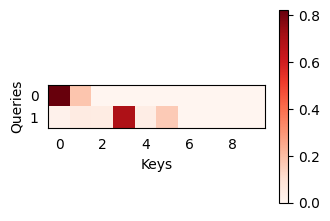

In [ ]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

Additive Attention

In [ ]:
class AdditiveAttention(nn.Module):
    """
    加性注意力机制（也称为Bahdanau注意力）

    原理：通过一个小的神经网络来计算查询和键之间的兼容性分数

    公式：注意力分数 = v^T * tanh(W_q * q + W_k * k)

    优点：适用于查询和键的维度不同的情况
    """

    def __init__(self, num_hiddens, dropout, **kwargs):
        """
        初始化加性注意力

        参数:
            num_hiddens: 隐藏层维度
            dropout: dropout比率
        """
        super().__init__(**kwargs)
        # 线性变换层：将键和查询映射到相同的隐藏空间
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)#用于键的变换
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)#用于查询的变换
        self.w_v = nn.LazyLinear(1, bias=False)#用于计算注意力分数
        self.dropout = nn.Dropout(dropout)#dropout层

    def forward(self, queries, keys, values, valid_lens):
       """
        前向传播

        参数:
            queries: 查询张量
            keys: 键张量
            values: 值张量
            valid_lens: 有效长度

        返回:
            加权求和后的结果
        """
       # 将键和查询映射到相同的隐藏空间
       queries, keys = self.W_q(queries), self.W_k(keys)
       features = queries.unsqueeze(2) + keys.unsqueeze(1)

       # 应用tanh激活函数
       features = torch.tanh(features)

       # 通过线性层计算注意力分数，并压缩最后一个维度
       scores = self.w_v(features).squeeze(-1)

       # 应用带掩码的softmax得到注意力权重
       self.attention_weights = masked_softmax(scores, valid_lens)

      #  对注意力权重应用dropout，然后与值相乘得到最终输出
       return torch.bmm(self.dropout(self.attention_weights), values)

See how `AdditiveAttention` works

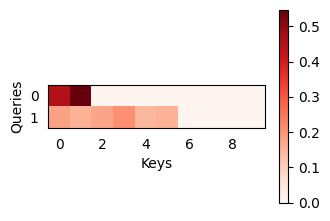

In [ ]:
queries = torch.normal(0, 1, (2, 1, 20))

# 创建点积注意力实例
attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()#设置为评估模式（关闭dropout）
check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

# 显示注意力权重热力图
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')